In [1]:
import numpy as np
import matplotlib.pylab as plt

import pymc as pm
import arviz as az
import aesara.tensor as at

import astropy.cosmology as cosmo
import astropy.units as u
import h5py

# Mock Data

(array([885, 922]),)

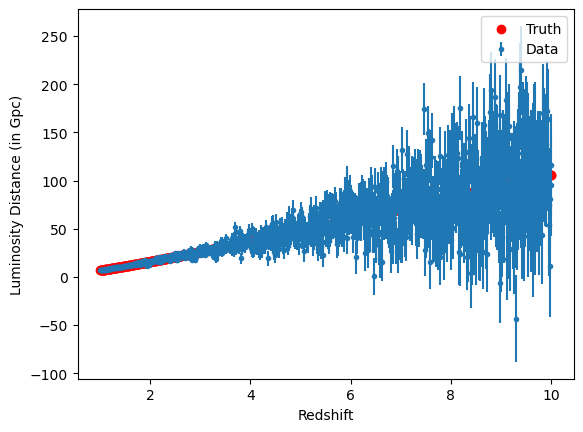

In [2]:
Nobs = 1000
z = np.linspace(1.0,10.0,Nobs)
cp = cosmo.Planck18
DL = cp.luminosity_distance(z).to(u.Gpc).value
sigma = 0.5*DL**2/cp.luminosity_distance(10).to(u.Gpc).value
Dobs = DL+sigma*np.random.randn(Nobs)
plt.errorbar(z, Dobs, yerr=sigma, fmt='.', label='Data')
plt.scatter(z, cp.luminosity_distance(z).to(u.Gpc).value, color='red', label='Truth')
plt.xlabel('Redshift')
plt.ylabel('Luminosity Distance (in Gpc)')
plt.legend()
np.where(Dobs<0)

# Estimation in Bins

Text(0, 0.5, 'Luminosity Distance (in Gpc)')

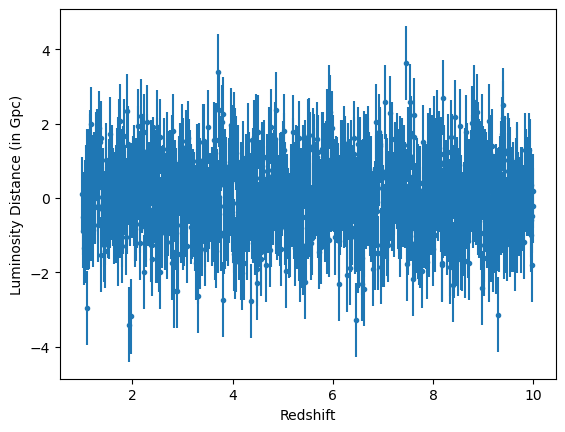

In [3]:
plt.errorbar(z, (Dobs-cp.luminosity_distance(z).to(u.Gpc).value)/sigma, yerr=np.ones(Nobs), fmt='.')
plt.xlabel('Redshift')
plt.ylabel('Luminosity Distance (in Gpc)')

In [4]:
Nbin = 50
zb = np.linspace(min(z), max(z), Nbin)
Dobs1 = np.zeros((len(Dobs),Nbin))
sigma1 = np.zeros((len(Dobs),Nbin))
for i in range(len(Dobs)):
    Dobs1[i].fill(Dobs[i])
    sigma1[i].fill(sigma[i])

In [5]:
with pm.Model() as model:
    beta = pm.Normal("beta", mu=10, sigma=15)
    logl = pm.Uniform("logl", -np.log(max(z)), np.log(max(z)))
    logs2f = pm.Uniform("logs2f", -5, 15)
    l = at.exp(logl)
    s2f = at.exp(logs2f)
    f_cov = s2f*pm.gp.cov.ExpQuad(1, l)
    gp = pm.gp.Latent(mean_func=pm.gp.mean.Linear(coeffs=beta, intercept=0), cov_func=f_cov)
    Db = gp.prior("Db", zb[:, None])
    
    prob = at.exp(pm.logp(pm.Normal.dist(Dobs1, sigma1), Db))
    prob1 = at.sum(prob, axis=1)
    print(np.where(prob1.eval()==0))
    pm.Potential("Posterior", at.sum(at.log(prob1)))

(array([], dtype=int64),)


In [6]:
with model:
    trace = pm.sample(target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, logl, logs2f, Db_rotated_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12969 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9688, but should be close to 0.99. Try to increase the number of tuning steps.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.


In [7]:
Db_fit = trace.posterior["Db"][0]
Db_med = np.median(Db_fit, axis=0)
Db_sd = np.std(Db_fit, axis=0)

Text(0, 0.5, 'Luminosity Distance (in Gpc)')

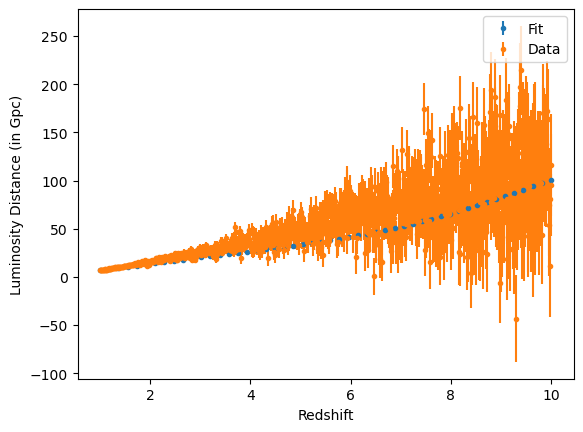

In [8]:
plt.errorbar(zb, Db_med, yerr=Db_sd, fmt='.', label="Fit")
plt.errorbar(z, Dobs, yerr=sigma, fmt='.', label="Data")
plt.legend()
plt.xlabel('Redshift')
plt.ylabel('Luminosity Distance (in Gpc)')

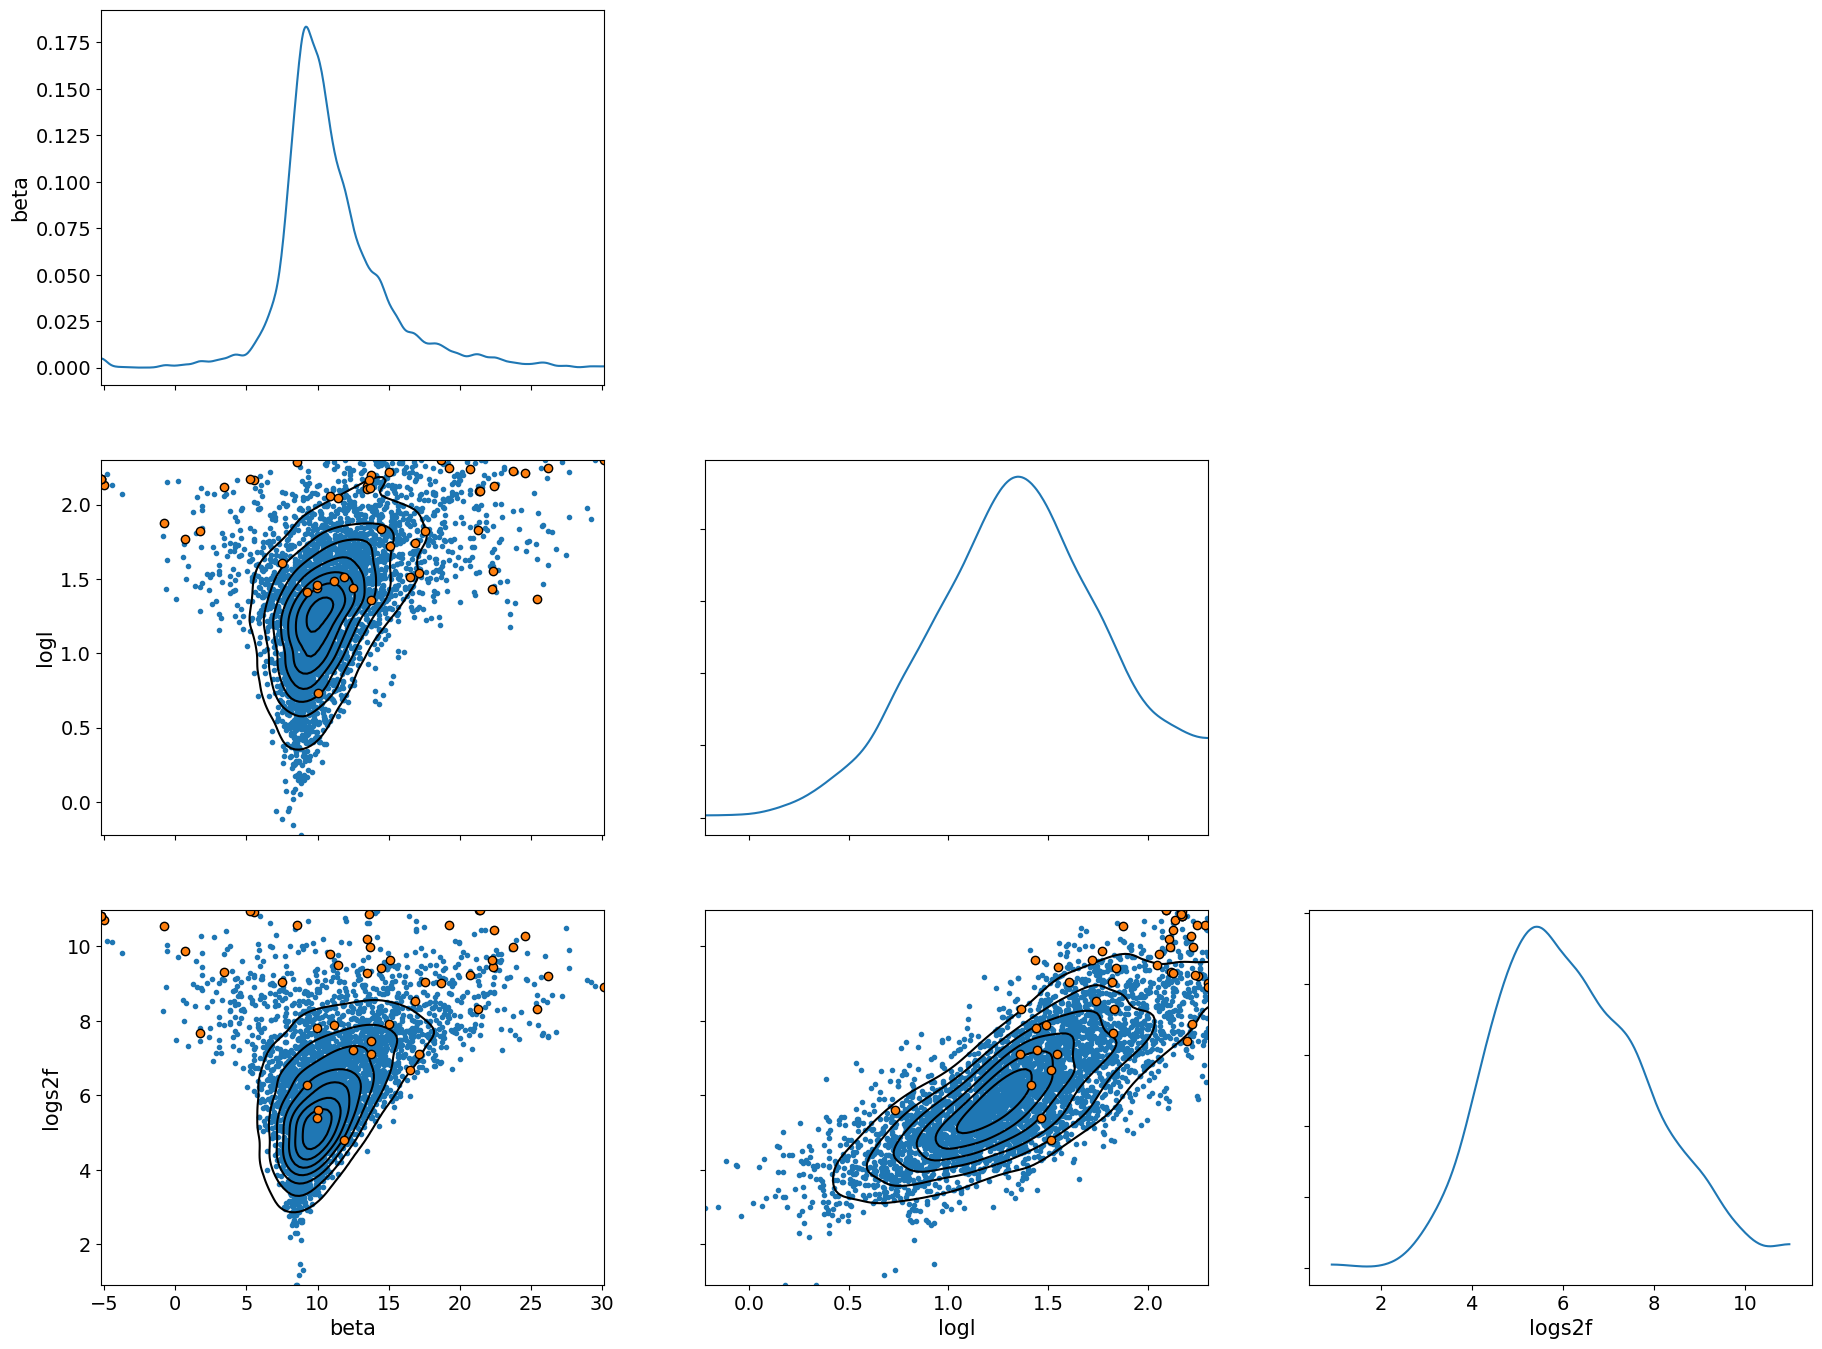

In [9]:
with model:
    axes = az.plot_pair(trace, var_names=["beta", "logl", "logs2f"], marginals=True, kind=['scatter', 'kde'],
                                          divergences=True)